In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

# Covid cases prediction

### 1. Loading data

In [2]:
full_dataset = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=['date'])
full_dataset

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165168,ZWE,Africa,Zimbabwe,2022-02-24,234967.0,378.0,338.429,5390.0,2.0,1.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165169,ZWE,Africa,Zimbabwe,2022-02-25,235467.0,500.0,348.143,5392.0,2.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165170,ZWE,Africa,Zimbabwe,2022-02-26,235803.0,336.0,368.429,5393.0,1.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165171,ZWE,Africa,Zimbabwe,2022-02-27,235803.0,0.0,350.143,5393.0,0.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [3]:
russian_cases = full_dataset.loc[full_dataset['iso_code'] == 'RUS'].set_index("date").sort_index()
russian_cases = russian_cases.loc[russian_cases.index >= "2020-03-03", ["total_cases", "new_cases"]]
russian_cases.loc[russian_cases['new_cases'] == 0, 'new_cases'] = 1
russian_cases['day_number'] = (russian_cases.index - russian_cases.index[0]).days
russian_cases

,total_cases,new_cases,day_number
date,,,
2020-03-03,3.0,1.0,0
2020-03-04,3.0,1.0,1
2020-03-05,4.0,1.0,2
2020-03-06,13.0,9.0,3
2020-03-07,13.0,1.0,4
...,...,...,...
2022-02-24,15697674.0,131249.0,723
2022-02-25,15819594.0,121920.0,724
2022-02-26,15941241.0,121647.0,725


### 2. Exponential regression

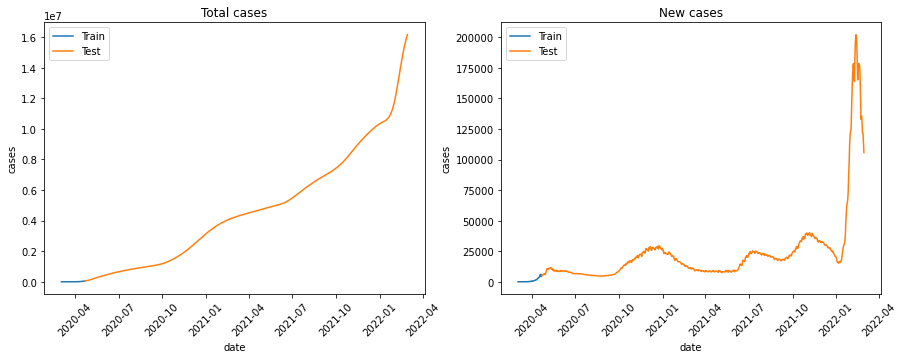

In [4]:
train_data = russian_cases.iloc[:50]
test_data = russian_cases.iloc[50:]

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(train_data.index, train_data['total_cases'], label='Train')
plt.plot(test_data.index, test_data['total_cases'], label='Test')
plt.title("Total cases")
plt.xlabel("date")
plt.xticks(rotation=45)
plt.ylabel("cases")
plt.legend()

plt.subplot(122)
plt.plot(train_data.index, train_data['new_cases'], label="Train")
plt.plot(test_data.index, test_data['new_cases'], label="Test")
plt.title("New cases")
plt.xlabel("date")
plt.xticks(rotation=45)
plt.ylabel("cases")
plt.legend()

plt.show()

#### a. Fitting

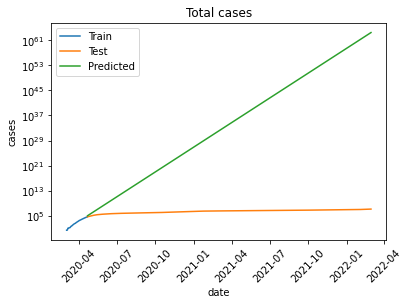

In [5]:
base_exp_model = LinearRegression()
base_exp_model.fit(train_data[['day_number']], np.log(train_data['total_cases']))
predictions = np.exp(base_exp_model.predict(test_data[['day_number']]))

plt.plot(train_data.index, train_data['total_cases'], label="Train")
plt.plot(test_data.index, test_data['total_cases'], label="Test")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Total cases")
plt.xlabel("date")
plt.xticks(rotation=45)
plt.ylabel("cases")
plt.yscale("log")
plt.legend()
plt.show()

#### b. Posterior Distribution

In [8]:
train_preds = base_exp_model.predict(train_data[['day_number']])
sigma_noise = np.mean(np.sqrt((train_preds - np.log(train_data['total_cases']))**2))

In [15]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

for px, py in zip(train_data['day_number'].values, np.log(train_data['total_cases']).values):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma_noise=sigma_noise)
print(cur_mu)
print(cur_sigma)

[1.8149615  0.19846573]
[[ 6.36530921e-03 -1.92887962e-04]
 [-1.92887962e-04  7.87945272e-06]]


#### c. Sampling

In [91]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [92]:
def plot_predictions(xs, mu, preds, true, sigma_noise, index):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(index, true, label="Правильный ответ")
    ax.plot(index, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.set_yscale("log")
    ax.fill_between(index, np.exp(mu[1]*xs + mu[0] - sigma_noise), np.exp(mu[1]*xs + mu[0] + sigma_noise), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(index,
                    np.exp(np.mean(preds, axis=0) - np.std(preds, axis=0)),
                    np.exp(np.mean(preds, axis=0) + np.std(preds, axis=0)),
                    color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

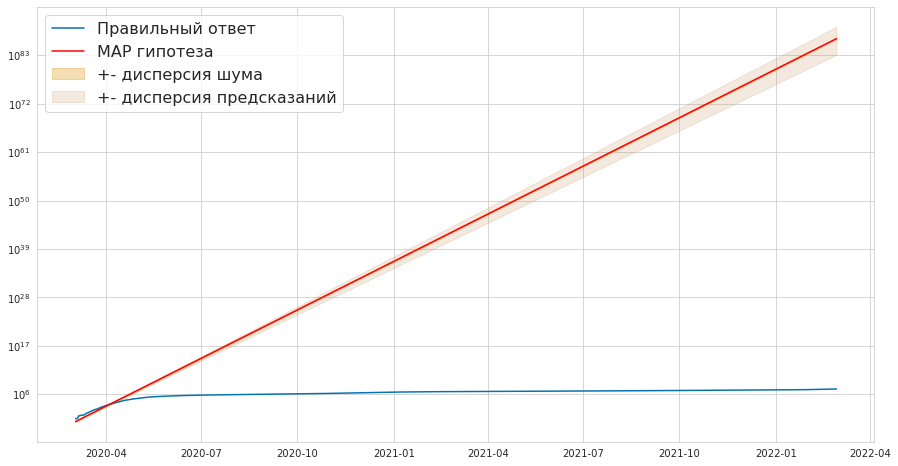

In [93]:
preds = sample_statistics(cur_mu, cur_sigma, russian_cases['day_number'].values, n=100)
plot_predictions(russian_cases['day_number'].values, cur_mu, preds, russian_cases['total_cases'],
                 sigma_noise=sigma_noise, index=russian_cases.index)

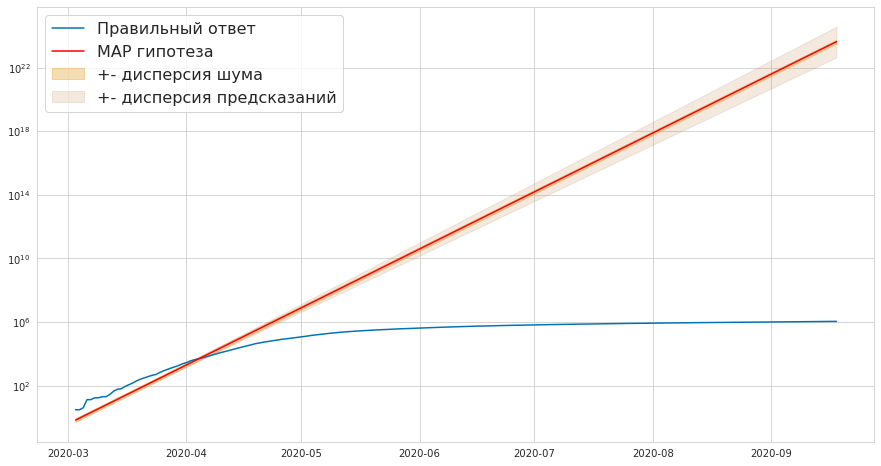

In [96]:
preds = sample_statistics(cur_mu, cur_sigma, russian_cases['day_number'].iloc[:200].values, n=100)
plot_predictions(russian_cases['day_number'].iloc[:200].values, cur_mu, preds, russian_cases['total_cases'].iloc[:200],
                 sigma_noise=sigma_noise, index=russian_cases.iloc[:200].index)

In [97]:
first_june = test_data.loc[pd.to_datetime('2020-06-01'), 'day_number']
preds = sample_statistics(cur_mu, cur_sigma, np.array([first_june]), n=100)
print(f"Prediction of total cases for June, 1st: {np.exp(np.mean(preds)):,.0f} ± {np.std(np.exp(preds)):,.0f}")

Prediction of total cases for June, 1st: 37,302,825,749 ± 53,945,691,160


In [98]:
first_sept = test_data.loc[pd.to_datetime('2020-09-01'), 'day_number']
preds = sample_statistics(cur_mu, cur_sigma, np.array([first_sept]), n=100)
print(f"Prediction of total cases for September, 1st: {np.exp(np.mean(preds)):,.0f} ± {np.std(np.exp(preds)):,.0f}")

Prediction of total cases for September, 1st: 3,017,256,613,792,318,488,576 ± 60,115,565,241,447,298,891,776


### 3. Sigmoid model

#### a. Method

Общее число заболевших можно аппроксимировать сигмоидой, соответствующей следующей формуле:

$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} \exp^{-t^2/2} dt $.

Для использования линейной регрессии, во-первых перенесем константу под экспоненту, и заменим выражение в экспоненте на линейно-квадратичную функцию.

$ \Phi(x) = \int_{-\infty}^{x} \exp^{w_0 + w_1 t + w_2 t^2} dt $.

Далее заметим, что выражение под интегралом соответствует новым случаем за день, и интегрирование проводится по всем дням с начала пандемии до текущего.
Тогда нижний предел в интеграле можно заменить на первый день пандемии, а выражение для новых случаев записать в виде:

$ y_{new} = \exp^{w_0 + w_1 t + w_2 t^2} $,

или, что то же самое,

$ \log y_{new} = w_0 + w_1 t + w_2 t^2 $.

С этим выражением можем работать как выше.

#### b. Posterior Distribution

In [99]:
quadro_new_model = LinearRegression()
train_data['day_squared'] = train_data['day_number']**2
quadro_new_model.fit(train_data[['day_number', 'day_squared']], np.log(train_data['new_cases']))
train_preds = quadro_new_model.predict(train_data[['day_number', 'day_squared']])
sigma_noise = np.mean(np.sqrt((train_preds - np.log(train_data['new_cases']))**2))

/tmp/ipykernel_186688/3591956488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['day_squared'] = train_data['day_number']**2


In [100]:
def bayesian_update_quadro(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n


cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.array([[1, 0, 0], [0, 1, 0],  [0, 0, 1]])

for px, py in zip(train_data['day_number'].values, np.log(train_data['new_cases']).values):
    cur_mu, cur_sigma = bayesian_update_quadro(cur_mu, cur_sigma, px, py, sigma_noise=sigma_noise)

print(cur_mu)
print(cur_sigma)

[-0.39379401  0.27539249 -0.00182588]
[[ 1.33523348e-02 -1.07877583e-03  1.81610638e-05]
 [-1.07877583e-03  1.19160310e-04 -2.27554723e-06]
 [ 1.81610638e-05 -2.27554723e-06  4.64751589e-08]]


#### c. Sampling

In [101]:
def sample_statistics_quadro(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i, w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs + w[2] * xs**2
    return res

In [102]:
def plot_predictions_sigmoid(xs, mu, preds, true, sigma_noise, index):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(index, true, label="Правильный ответ")
    ax.plot(index, np.cumsum(np.exp(mu[2]*xs**2 + mu[1]*xs + mu[0])), color="red", label="MAP гипотеза")
    #ax.set_yscale("log")
    ax.fill_between(index,
                    np.cumsum(np.exp(mu[2]*xs**2 + mu[1]*xs + mu[0] - sigma_noise)),
                    np.cumsum(np.exp(mu[2]*xs**2 + mu[1]*xs + mu[0] + sigma_noise)),
                    color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(index,
                    np.cumsum(np.exp(np.mean(preds, axis=0) - np.std(preds, axis=0))),
                    np.cumsum(np.exp(np.mean(preds, axis=0) + np.std(preds, axis=0))),
                    color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

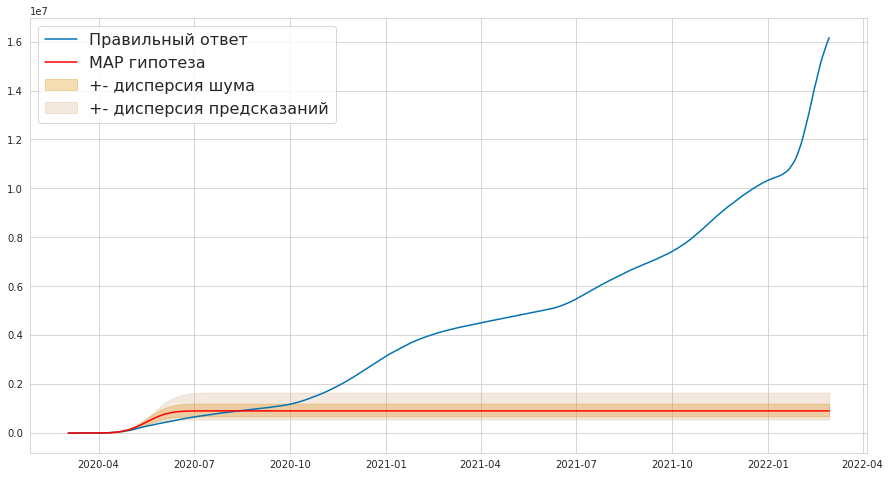

In [103]:
preds = sample_statistics_quadro(cur_mu, cur_sigma, russian_cases['day_number'].values, n=100)
plot_predictions_sigmoid(russian_cases['day_number'].values, cur_mu, preds, russian_cases['total_cases'],
                         sigma_noise=sigma_noise, index=russian_cases.index)

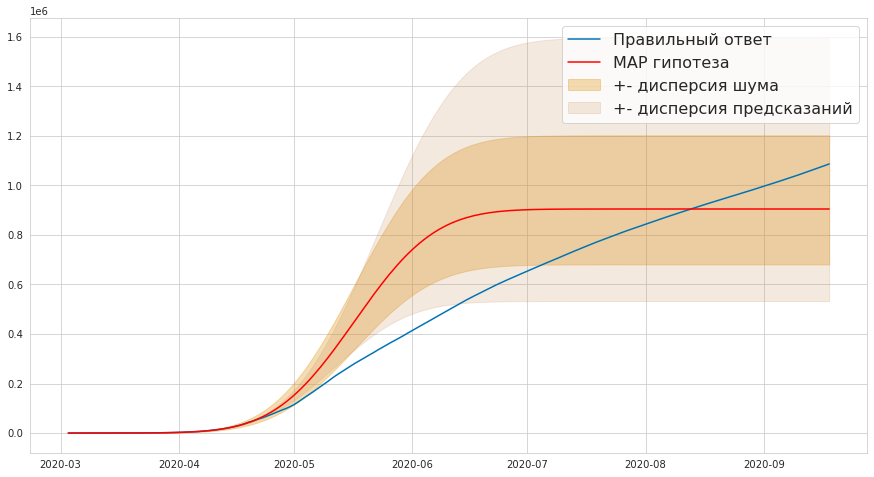

In [105]:
preds = sample_statistics_quadro(cur_mu, cur_sigma, russian_cases['day_number'].iloc[:200].values, n=100)
plot_predictions_sigmoid(russian_cases['day_number'].iloc[:200].values, cur_mu, preds, russian_cases['total_cases'].iloc[:200],
                         sigma_noise=sigma_noise, index=russian_cases.iloc[:200].index)

In [121]:
first_june = test_data.loc[:pd.to_datetime('2020-06-01'), 'day_number']
preds = sample_statistics_quadro(cur_mu, cur_sigma, first_june.values, n=1000)
preds = np.cumsum(np.exp(preds), axis=1)
print(f"Prediction of total cases for June, 1st: {np.mean(preds[:, -1]):,.0f} ± {np.std(preds[:, -1]):,.0f}")

Prediction of total cases for June, 1st: 794,364 ± 417,357


In [122]:
first_sept = test_data.loc[:pd.to_datetime('2020-09-01'), 'day_number']
preds = sample_statistics_quadro(cur_mu, cur_sigma, first_sept.values, n=1000)
preds = np.cumsum(np.exp(preds), axis=1)
print(f"Prediction of total cases for June, 1st: {np.mean(preds[:, -1]):,.0f} ± {np.std(preds[:, -1]):,.0f}")

Prediction of total cases for June, 1st: 1,171,557 ± 1,043,732


In [125]:
preds = sample_statistics_quadro(cur_mu, cur_sigma, russian_cases['day_number'].values, n=100)
preds = np.cumsum(np.exp(preds), axis=1)
print("Total number of cases:")
print(f"Optimistic (0.1-quantile): {np.quantile(preds[:, -1], 0.1):,.2f}")
print(f"Median: {np.median(preds[:, -1]):,.2f}")
print(f"Pessimistic (0.9-quantile): {np.quantile(preds[:, -1], 0.9):,.2f}")

Total number of cases:
Optimistic (0.1-quantile): 499,809.55
Median: 932,357.58
Pessimistic (0.9-quantile): 2,218,786.94


### 5. Results

Модель сигмоиды не учитывает волновой характер пандемии, появление новых штамов и введение карантинов.
Её можно использовать для предсказания первой волны, так же возможно комбинировать несколько сигмоид со сдвигом.
Из результата модели на первых месяцах можно предположить, что введение самоизоляции и каникул в конце апреля действительно
помогло сгладить кривую заражений.